 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#moduleのインポート・初期値設定" data-toc-modified-id="moduleのインポート・初期値設定-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>moduleのインポート・初期値設定</a></span></li><li><span><a href="#オプティカルフロー" data-toc-modified-id="オプティカルフロー-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>オプティカルフロー</a></span></li><li><span><a href="#差分検知" data-toc-modified-id="差分検知-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>差分検知</a></span></li><li><span><a href="#差分検出：動体の輪郭をとる" data-toc-modified-id="差分検出：動体の輪郭をとる-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>差分検出：動体の輪郭をとる</a></span></li><li><span><a href="#解析" data-toc-modified-id="解析-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>解析</a></span><ul class="toc-item"><li><span><a href="#a" data-toc-modified-id="a-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>a</a></span></li><li><span><a href="#4.1" data-toc-modified-id="4.1-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>4.1</a></span></li><li><span><a href="#可視化" data-toc-modified-id="可視化-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>可視化</a></span></li><li><span><a href="#second-database" data-toc-modified-id="second-database-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>second database</a></span></li><li><span><a href="#REM-or-NONREM" data-toc-modified-id="REM-or-NONREM-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>REM or NONREM</a></span></li></ul></li></ul></div>

### moduleのインポート・初期値設定

In [3]:
import pandas as pd
import datetime
import cv2
import pickle
import numpy as np
import time
from tqdm import tqdm
%matplotlib inline

In [4]:
# csvファイルからAnnotateされてあるMouseの情報を取得
df = pd.read_csv('ID47680.auto.stage.csv')
# 時間
df['time'] = ['{}:{}:{}'.format(i*8//3600, ( i * 8 //60) % 60, i * 8 %60) for i in df.index]
# 覚醒/ REM睡眠 / NonREM睡眠
df['flag'] = [0 if flag == 'Wake' else (1 if flag =='REM' else 2) for flag in df['# Mouse.ID: ID47680']]
df['datetime'] = [datetime.datetime(2018, 2, 15, 8) +  datetime.timedelta(seconds=i * 8) for i in df.index]

In [9]:
# 定数
ESC_KEY = 27     # Escキー
INTERVAL= 33     # インターバル
FRAME_RATE = 100  # fps

WINDOW_ORG = "org"
WINDOW_BACK = "back"
WINDOW_DIFF = "diff"
DIFF_BOOL='bool'
BASE_FILE = 'Movie2/'
FILE_ORG = BASE_FILE + movie

# ビデオの読み込み(VideoCapture()に動画ファイルを指定したパターン)
video = cv2.VideoCapture(FILE_ORG)
cap = cv2.VideoCapture(FILE_ORG)            # 動画を読み込む
video_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT) # フレーム数を取得する
print('frame:', video_frame)
video_fps = cap.get(cv2.CAP_PROP_FPS)           # FPS を取得する
print('fps:', video_fps)
video_len_sec = video_frame / video_fps         # 長さ（秒）を計算する
print(video_len_sec)                            # 長さ（秒）を出力する
video_fps = cap.get(cv2.CAP_PROP_FPS)           # FPS を取得する
W = video.get(cv2.CAP_PROP_FRAME_WIDTH)
# 高さ
H = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
print(W,H)
# 動画保存方法
# fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# fps = video_fps
# size = (640, 480)
# writer = cv2.VideoWriter('outtest.m4v', fmt, fps, size)


frame: 65401.0
fps: 15.019976568836553
4354.267778
640.0 480.0


### オプティカルフロー

In [23]:
# オプティカルフロー

# Shi-Tomasiのコーナー検出パラメータ
feature_params = dict( maxCorners = 50,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Lucas-Kanade法のパラメータ
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# ランダムに色を１００個生成（値0～255の範囲で100行3列のランダムなndarrayを生成）
color = np.random.randint(0, 255, (100, 3))

# 最初のフレームの処理
end_flag, frame = cap.read()
frame = frame[55:, :]
gray_prev = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
feature_prev = cv2.goodFeaturesToTrack(gray_prev, mask = None, **feature_params)
mask = np.zeros_like(frame)

while(end_flag):
    # グレースケールに変換
    gray_next = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # オプティカルフロー検出
    feature_next, status, err = cv2.calcOpticalFlowPyrLK(gray_prev, gray_next, feature_prev, None, **lk_params)

    # オプティカルフローを検出した特徴点を選別（0：検出せず、1：検出した）
    good_prev = feature_prev[status == 1]
    good_next = feature_next[status == 1]

    # オプティカルフローを描画
    for i, (next_point, prev_point) in enumerate(zip(good_next, good_prev)):
        prev_x, prev_y = prev_point.ravel()
        next_x, next_y = next_point.ravel()
        mask = cv2.line(mask, (next_x, next_y), (prev_x, prev_y), color[i].tolist(), 2)
        frame = cv2.circle(frame, (next_x, next_y), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)

    # ウィンドウに表示
    cv2.imshow('window', img)
    writer.write(img)


    # ESCキー押下で終了
    if cv2.waitKey(30) & 0xff == 27:
        break

    # 次のフレーム、ポイントの準備
    gray_prev = gray_next.copy()
    feature_prev = good_next.reshape(-1, 1, 2)
    end_flag, frame = cap.read()
    try:
        frame = frame[55:, :]
    except:
        print('!')
writer.release()

# 終了処理
cv2.destroyAllWindows()
cap.release()


### 差分検知

In [ ]:
diff_pixels = []
mov_org = cv2.VideoCapture(FILE_ORG)
# 最初のフレーム読み込み
has_next, i_frame = mov_org.read()
# i_frame = i_frame[55:, :]
count = 1

# 背景フレーム, 上部の時間表示を切り取る
back_frame = np.zeros_like(i_frame[55:,:], np.float32)

# 変換処理ループ
while has_next == True:
    if count % 500 == 0:
        print('finshed {}'.format(count))
    i_frame = i_frame[55:, :]
    # 入力画像を浮動小数点型に変換
    f_frame = i_frame.astype(np.float32)
    diff_frame = cv2.absdiff(f_frame, back_frame)

    # 背景の更新
    cv2.accumulateWeighted(f_frame, back_frame, 0.025)
    
    # 二種類のthresholdで白黒に
    mask = diff_frame.copy()
    mask2 = diff_frame.copy()
    th = 50
    mask[mask < th] = 0
    mask[mask >= th] = 255
    th=100
    mask2[mask2 < th] = 0
    mask2[mask2 >= th] = 255

    pred = clf.predict([[mean_0(len(mask[mask >= 1])), mean_1(len(mask2[mask2 >= 1]))]])
    areaframe = i_frame
    cv2.putText(areaframe, str(pred), (0,50), cv2.FONT_HERSHEY_PLAIN, 3, (0, 255,0), 3, cv2.LINE_AA)

    cv2.imshow('MotionDetected Area Frame', areaframe)

    # Escキーで終了
    key = cv2.waitKey(INTERVAL)
    if key == ESC_KEY:
        break

    # 次のフレーム読み込み
    has_next, i_frame = mov_org.read()
    count += 1

# 終了処理
cv2.destroyAllWindows()
mov_org.release()


### 差分検出：動体の輪郭をとる

In [24]:
# 動いているものの輪郭をとってから解析してみる
cap = cv2.VideoCapture(FILE_ORG)
before = None
while True:
    #  OpenCVで動画を取り込む
    ret, frame = cap.read()

    # 加工なし画像を表示する
    cv2.imshow('Raw Frame', frame)

    # 取り込んだフレームに対して差分をとって動いているところが明るい画像を作る
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if before is None:
        before = gray.copy().astype('float')
        continue
    # 現フレームと前フレームの加重平均を使うと良いらしい
    cv2.accumulateWeighted(gray, before, 0.5)
    mdframe = cv2.absdiff(gray, cv2.convertScaleAbs(before))
    # 動いているところが明るい画像を表示する
    cv2.imshow('MotionDetected Frame', mdframe)

    # 動いているエリアの面積を計算してちょうどいい検出結果を抽出する
    thresh = cv2.threshold(mdframe, 3, 255, cv2.THRESH_BINARY)[1]
    # 輪郭データに変換しくれるfindContours
    image, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    target = contours[0]
    for cnt in contours:
         #輪郭の面積を求めてくれるcontourArea
        area = cv2.contourArea(cnt)
        if max_area < area and area < 10000 and area > 1000:
            max_area = area;
            target = cnt

    # 動いているエリアのうちそこそこの大きさのものがあればそれを矩形で表示する
    if max_area <= 1000:
        areaframe = frame
        cv2.putText(areaframe, 'not detected', (0,50), cv2.FONT_HERSHEY_PLAIN, 3, (0, 255,0), 3, cv2.LINE_AA)
    else:
        # 諸般の事情で矩形検出とした。
        x,y,w,h = cv2.boundingRect(target)
        areaframe = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

    cv2.imshow('MotionDetected Area Frame', areaframe)
    # キー入力を1ms待って、k が27（ESC）だったらBreakする
    k = cv2.waitKey(1)
    if k == 27:
        break

# キャプチャをリリースして、ウィンドウをすべて閉じる
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

### 解析

#### a

In [4]:
with open('video_result.pickle', 'rb') as f:
    results = pickle.load(f)
# with open('video_result.pickle', 'wb') as f:
#     pickle.dump(results, f)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1420e8d0>,
      dtype=object)

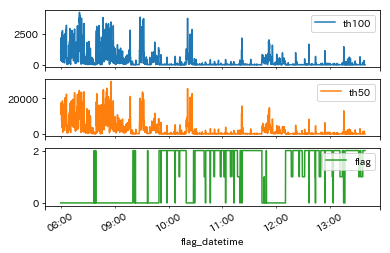

In [5]:
results = results.dropna()
results[results['th50'] < 200][:3]
grouped_table = pd.DataFrame(results.groupby(['flag_datetime'])['th100', 'th50', 'flag'].mean())
grouped_table.plot(y = ['th100', 'th50', 'flag'], subplots=True)

In [13]:
frame_flag_dates = []
flags = []
for frame_date in tqdm.tqdm(results['datetime'].values):
    frame_flag_date = pd.to_datetime(frame_date) - (pd.to_datetime(frame_date)  - datetime.datetime(2018, 2,15, 8) ) % datetime.timedelta(seconds=8)
    flag = df[df['datetime'].isin([frame_flag_date])]['flag'].values
    if list(flag) == []:
        flags.append(None)
    else:
        flags.append(flag[0])
    frame_flag_dates.append(frame_flag_date)
results['flag_datetime'] = frame_flag_dates
results['flag'] = flags

Index(['movie', 'count', 'th50', 'th100', 'datetime', 'flag_datetime', 'flag'], dtype='object')

In [6]:
X = results['th100']

In [7]:
results = results.dropna()

In [8]:
results[results['th50'] < 200][:3]

,movie,count,th50,th100,datetime,flag_datetime,flag
18825,Record-2018-02-15_07-41-23.avi,18827,168,0,2018-02-15 08:02:16.397428,2018-02-15 08:02:16,0.0
18840,Record-2018-02-15_07-41-23.avi,18842,179,0,2018-02-15 08:02:17.396098,2018-02-15 08:02:16,0.0
18842,Record-2018-02-15_07-41-23.avi,18844,184,0,2018-02-15 08:02:17.529254,2018-02-15 08:02:16,0.0


In [9]:
grouped_table = pd.DataFrame(results.groupby(['flag_datetime'])['th100'].apply(np.array))
X = grouped_table['th100'].values

In [10]:
grouped_table2 = pd.DataFrame(results.groupby(['flag_datetime'])['flag'].mean())
y = grouped_table2['flag'].values
from collections import Counter
Counter(y)

Counter({0.0: 1105, 1.0: 175, 2.0: 1261})

In [11]:
len(merge_data_benign)

NameError: name 'merge_data_benign' is not defined

In [12]:
X_120 = np.array(list([list(i) for i in X if len(i) ==120]))
X_index = np.array(list([True  if len(i) ==120 else False for i in X]))

In [13]:
y_120 = y[X_index]

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


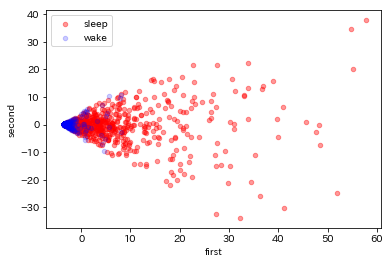

In [27]:
from sklearn.preprocessing import StandardScaler
# PCA
from sklearn.decomposition import PCA

sc = StandardScaler()
sc.fit(X_120)
X_scaled = sc.transform(X_120)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
merge_data = pd.concat([pd.DataFrame(X_pca[:,0]),pd.DataFrame(X_pca[:,1]),pd.DataFrame(y_120)]
                       ,axis=1)
merge_data.columns = ["first","second","target"]
merge_data_malignant = merge_data[merge_data["target"]==0]
merge_data_benign = merge_data[merge_data["target"]!=0]
ax =merge_data_malignant.plot.scatter(x='first', y='second', color='red',alpha=0.4, label='sleep');
merge_data_benign.plot.scatter(x='first', y='second', color='blue',alpha=0.2, label='wake',ax=ax);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12e2e04e0>,
      dtype=object)

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


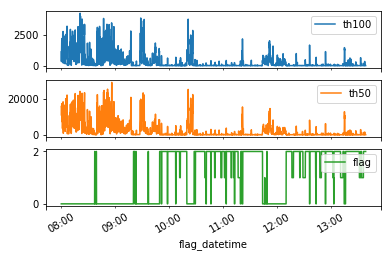

In [112]:
grouped_table.plot(y = ['th100', 'th50', 'flag'], subplots=True)

In [16]:
with open('video_Record-2018-02-15_07-41-23.avi.pickle', 'rb') as f:
    results_07 = pickle.load(f)

In [19]:
results = pd.DataFrame(columns=['movie', 'count', 'th50', 'th100'], data=results_07)

In [38]:
def create_df_from_pickle(pickle_file):
    with open(pickle_file, 'rb') as f:
        results_ = pickle.load(f)
    results = pd.DataFrame(columns=['movie', 'count', 'th50', 'th100'], data=results_)
    start_time = datetime.datetime.strptime(pickle_file , 'video_Record-%Y-%m-%d_%H-%M-%S.avi.pickle')
    time_per_frame =  datetime.timedelta(seconds= 1/ video_fps)
    results['datetime'] = [start_time + time_per_frame * (i+1)  for i in results.index]
    frame_flag_dates = []
    flags = []
    for frame_date in tqdm(results['datetime'].values):
        frame_flag_date = pd.to_datetime(frame_date) - (pd.to_datetime(frame_date)  - datetime.datetime(2018, 2,15, 8) ) % datetime.timedelta(seconds=8)
        flag = df[df['datetime'].isin([frame_flag_date])]['flag'].values
        if list(flag) == []:
            flags.append(None)
        else:
            flags.append(flag[0])
        frame_flag_dates.append(frame_flag_date)
    results['flag_datetime'] = frame_flag_dates
    results['flag'] = flags
    return results

In [1]:
pickles = !ls | grep pickle

In [399]:
dfs_pickled = []
for pickle_file in pickles:
    df_pickled = create_df_from_pickle(pickle_file)
    dfs_pickled.append(df_pickled)
df_merged_2 = pd.concat(dfs_pickled)

100%|██████████| 65404/65404 [01:40<00:00, 653.24it/s]


In [40]:
df_pickled = create_df_from_pickle(pickles[0])

100%|██████████| 65401/65401 [01:44<00:00, 628.49it/s]


In [73]:
df1 = create_df_from_pickle(pickles[1])

100%|██████████| 65302/65302 [01:44<00:00, 622.59it/s]


In [46]:
df2 = create_df_from_pickle(pickles[2])

100%|██████████| 63778/63778 [01:37<00:00, 652.37it/s]


In [63]:
df3 = create_df_from_pickle(pickles[3])

100%|██████████| 63960/63960 [01:42<00:00, 626.73it/s]


In [84]:
df4 = create_df_from_pickle(pickles[4])

100%|██████████| 63427/63427 [01:19<00:00, 794.01it/s]


In [85]:
df_merged = pd.concat([df_pickled, df1, df2, df3, df4])

In [2]:
results = df_merged_2
results = results[results['th100'] < 10000]
results = results[results['th50'] < 40000]

NameError: name 'df_merged_2' is not defined

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a407ed438>,
      dtype=object)

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


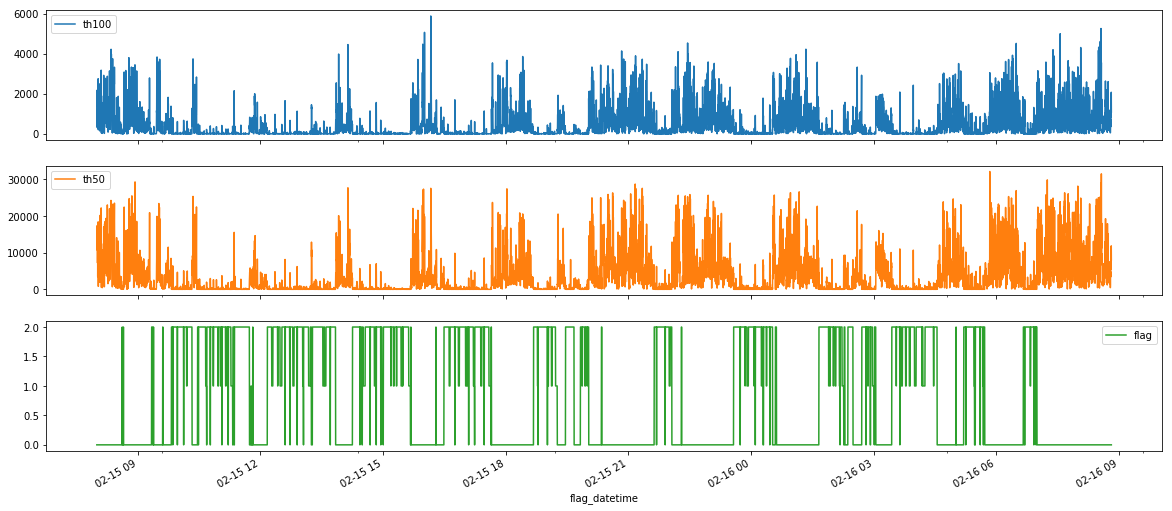

In [404]:
results = results.dropna()
results[results['th50'] < 200][:3]
grouped_table = pd.DataFrame(results.groupby(['flag_datetime'])['th100', 'th50', 'flag'].mean())
grouped_table.plot(y = ['th100', 'th50', 'flag'], subplots=True, figsize=(20,9))

#### 4.1


In [131]:
import scipy

In [193]:
x = results[['th50', 'th100']].as_matrix()
X = scipy.stats.zscore(x)
y = results['flag'].values

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [195]:
results_x  = x
def mean_0(th50):
    return (th50 - np.mean(results_x[:, 0])) / np.std(results_x[:, 0])

def mean_1(th100):
    return (th100 - np.mean(results_x[:, 1])) / np.std(results_x[:, 1])

In [135]:

x = grouped_table[['th50', 'th100']].as_matrix()
X = scipy.stats.zscore(x)
y = grouped_table['flag'].values

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [138]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score


data_x = pd.DataFrame(X).as_matrix()
data_y = pd.DataFrame(y, columns=['target']).as_matrix().ravel()
data_y = [1 if i > 0 else 0 for i in data_y]
# clf = RandomForestClassifier()
clf = AdaBoostClassifier()
clf.fit(data_x, data_y)

# cv　で分割数を決定する。デフォルトは3。
scores = cross_val_score(clf, data_x, data_y,cv=5)

print("Cross validation scores:{}".format(scores))
print("Cross validation scores:{}".format(scores.mean()))

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Cross validation scores:[0.89397347 0.92427149 0.88586974 0.9254267  0.88247552]
Cross validation scores:0.9024033863805961


In [145]:
if clf.predict([[ 3.03605781, -0.22503037]]) == [1] :
    print('a')

In [415]:
Counter(y)

Counter({0.0: 6102, 1.0: 619, 2.0: 4446})

In [329]:
def check_params(x, label='mean'):
    X = scipy.stats.zscore(x)
    data_x = pd.DataFrame(X)
    clf = AdaBoostClassifier()
    clf.fit(data_x, data_y)
    # cv　で分割数を決定する。デフォルトは3。
    scores = cross_val_score(clf, data_x, data_y,cv=5)

    print("{}::Cross validation scores:{}".format(label, scores))
    print("{}::Cross validation scores:{}".format(label, scores.mean()))
    return label, scores.mean()

In [224]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
# clf = RandomForestClassifier()
clf = AdaBoostClassifier()
clf.fit(data_x, data_y)

# cv　で分割数を決定する。デフォルトは3。
scores = cross_val_score(clf, data_x, data_y,cv=5)

print("Cross validation scores:{}".format(scores))
print("Cross validation scores:{}".format(scores.mean()))
return 

Cross validation scores:[0.89397347 0.92427149 0.88586974 0.9254267  0.88247552]
Cross validation scores:0.9024033863805961


In [410]:
400/ len(a)

0.03581982627384257

In [409]:
from collections import Counter
pred_x = clf.predict(data_x)
a  =list(zip(pred_x,data_y))
Counter(a)

Counter({(0, 0): 6010, (0, 1): 399, (1, 0): 92, (1, 1): 4666})

In [180]:
ll = [-1 if i == (0,1.0) else 1 if i == (1.0,0) else 0 for i in list(zip(pred_x, data_y))]
grouped_table['correct']  = ll
grouped_table.plot(subplots=True, figsize=(20,9))

In [129]:
import scipy

from sklearn import preprocessing

ss = preprocessing.StandardScaler()
l_2d_standardization = ss.fit_transform(l_2d)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

#### 可視化

In [423]:
grouped_table_median = pd.DataFrame(data=results.groupby(['flag_datetime'])['flag', 'th100', 'th50'].median().values, columns=['flag', 'th100_median', 'th50_median', ])
grouped_table_sum = pd.DataFrame(results.groupby(['flag_datetime'])['th100', 'th50', ].sum().values, columns=['th100_sum', 'th50_sum'])
grouped_table_min = pd.DataFrame(results.groupby(['flag_datetime'])['th100', 'th50', ].min().values, columns=['th100_min', 'th50_min'])
grouped_table_max = pd.DataFrame(results.groupby(['flag_datetime'])['th100', 'th50', ].max().values, columns=['th100_max', 'th50_max'])
grouped_table_mean= pd.DataFrame(results.groupby(['flag_datetime'])['th100', 'th50', ].mean().values, columns=['th100_mean', 'th50_mean'])

table_merged = pd.concat([grouped_table_median, grouped_table_max, grouped_table_mean, grouped_table_min, grouped_table_sum], axis=1)

In [479]:
table_merged[:3]

,flag,th100_median,th50_median,th100_max,th50_max,th100_mean,th50_mean,th100_min,th50_min,th100_sum,th50_sum
0,0.0,592.5,14802.0,9192,31974,1110.574468,15800.297872,78,9240,104394,1485228
1,0.0,218.0,12067.0,1316,35298,334.142857,14731.734694,5,3375,16373,721855
2,0.0,557.0,10796.0,4873,20229,1040.325000,10749.350000,34,2578,124839,1289922


In [330]:
table_merged.columns[1:]
# x = table_merged[['th100_median', 'th50_median', 'th100_mean', 'th50_mean',]].values

Index(['th100_median', 'th50_median', 'th100_mean', 'th50_mean', 'th100_max',
       'th50_max', 'th100_min', 'th50_min', 'th100_sum', 'th50_sum'],
      dtype='object')

In [480]:
array2 = []

In [517]:
for pattern in combinations(cols, 1):
    x = table_merged[list(pattern)].values
    l, score = check_params(x, str(pattern))
    array2.append([l,score])

('th100_median',)::Cross validation scores:[0.91316025 0.9301701  0.97357815 0.9632781  0.96417376]
('th100_median',)::Cross validation scores:0.9488720707255576
('th50_median',)::Cross validation scores:[0.92972247 0.95120859 0.97268249 0.95656068 0.95118674]
('th50_median',)::Cross validation scores:0.9522721960532599
('th100_mean',)::Cross validation scores:[0.88137869 0.8863026  0.95700851 0.92521272 0.92297358]
('th100_mean',)::Cross validation scores:0.9145752188724436
('th50_mean',)::Cross validation scores:[0.89570278 0.91987466 0.96551724 0.93819973 0.93999104]
('th50_mean',)::Cross validation scores:0.9318570911384174
('th100_max',)::Cross validation scores:[0.86123545 0.87197851 0.90326914 0.89923869 0.87550381]
('th100_max',)::Cross validation scores:0.8822451219018378
('th50_max',)::Cross validation scores:[0.86571173 0.88764548 0.94446932 0.9072996  0.90371697]
('th50_max',)::Cross validation scores:0.9017686200441734
('th100_min',)::Cross validation scores:[0.7045658  0.

In [518]:
pd.DataFrame(array2).sort_values([1], ascending=False).values[:7]

array([["('th100_median', 'th50_median', 'th100_mean', 'th50_max', 'th100_min', 'th50_min', 'th100_sum', 'th50_sum')",
        0.9649887080782644],
       ["('th100_median', 'th50_median', 'th100_mean', 'th100_max', 'th50_max', 'th100_min', 'th50_min', 'th100_sum', 'th50_sum')",
        0.9648991023794222],
       ["('th50_median', 'th100_mean', 'th50_mean', 'th100_max', 'th50_max', 'th100_min', 'th50_min', 'th100_sum', 'th50_sum')",
        0.9643619893828272],
       ["('th50_median', 'th50_mean', 'th100_max', 'th50_max', 'th100_min', 'th50_min', 'th100_sum', 'th50_sum')",
        0.9643619893828272],
       ["('th100_median', 'th50_median', 'th100_mean', 'th100_max', 'th50_max', 'th100_min', 'th50_min', 'th100_sum')",
        0.964361949290792],
       ["('th50_median', 'th100_mean', 'th50_mean', 'th100_max', 'th50_max', 'th100_min', 'th50_min', 'th50_sum')",
        0.9641828581692133],
       ["('th50_median', 'th50_mean', 'th50_min')", 0.9637357918838486]],
      dtype=object)

In [486]:
pd.DataFrame(array).sort_values([1], ascending=False)[0].values[:4]

array(["('th50_median', 'th100_mean', 'th100_min', 'th50_min')",
       "('th100_median', 'th50_median', 'th100_mean', 'th50_mean', 'th50_max', 'th50_min', 'th50_sum')",
       "('th100_median', 'th50_median', 'th100_mean', 'th50_max', 'th100_min', 'th50_min', 'th100_sum')",
       "('th50_median', 'th100_mean', 'th50_max', 'th100_min', 'th50_min', 'th100_sum', 'th50_sum')"],
      dtype=object)

#### second database

In [525]:
def create_df_from_pickle2(pickle_file):
    with open(pickle_file, 'rb') as f:
        results_ = pickle.load(f)
    results = pd.DataFrame(columns=['movie', 'count', 'th30','th50','th100', 'th150'], data=results_)
    start_time = datetime.datetime.strptime(pickle_file , 'video_Record-%Y-%m-%d_%H-%M-%S.avi2.pickle')
    time_per_frame =  datetime.timedelta(seconds= 1/ video_fps)
    results['datetime'] = [start_time + time_per_frame * (i+1)  for i in results.index]
    frame_flag_dates = []
    flags = []
    for frame_date in tqdm(results['datetime'].values):
        frame_flag_date = pd.to_datetime(frame_date) - (pd.to_datetime(frame_date)  - datetime.datetime(2018, 2,15, 8) ) % datetime.timedelta(seconds=8)
        flag = df[df['datetime'].isin([frame_flag_date])]['flag'].values
        if list(flag) == []:
            flags.append(None)
        else:
            flags.append(flag[0])
        frame_flag_dates.append(frame_flag_date)
    results['flag_datetime'] = frame_flag_dates
    results['flag'] = flags
    return results

In [526]:
pickles = !ls | grep .avi2.pickle
pickles = pickles
pickles

['video_Record-2018-02-15_07-41-23.avi2.pickle',
 'video_Record-2018-02-15_08-53-59.avi2.pickle',
 'video_Record-2018-02-15_10-06-28.avi2.pickle',
 'video_Record-2018-02-15_11-17-19.avi2.pickle',
 'video_Record-2018-02-15_12-28-23.avi2.pickle',
 'video_Record-2018-02-15_13-38-48.avi2.pickle',
 'video_Record-2018-02-15_14-49-59.avi2.pickle',
 'video_Record-2018-02-15_16-01-01.avi2.pickle',
 'video_Record-2018-02-15_17-12-08.avi2.pickle',
 'video_Record-2018-02-15_18-24-08.avi2.pickle',
 'video_Record-2018-02-15_19-35-23.avi2.pickle',
 'video_Record-2018-02-15_20-47-28.avi2.pickle',
 'video_Record-2018-02-15_21-59-48.avi2.pickle',
 'video_Record-2018-02-15_23-12-45.avi2.pickle',
 'video_Record-2018-02-16_00-24-12.avi2.pickle',
 'video_Record-2018-02-16_01-36-56.avi2.pickle',
 'video_Record-2018-02-16_02-48-24.avi2.pickle',
 'video_Record-2018-02-16_03-59-51.avi2.pickle',
 'video_Record-2018-02-16_05-11-46.avi2.pickle',
 'video_Record-2018-02-16_06-23-58.avi2.pickle']

In [ ]:
dfs_pickled = []
for pickle_file in pickles[:3]:
    df_pickled = create_df_from_pickle2(pickle_file)
    dfs_pickled.append(df_pickled)
df_merged_3 = pd.concat(dfs_pickled)

 83%|████████▎ | 52813/63778 [01:21<00:16, 645.81it/s]

#### REM or NONREM

In [425]:
x = table_merged[['th100_min', 'th50_min']].values
x = table_merged[['th100_median', 'th50_median', 'th50_max', 'th100_sum']].values
X = scipy.stats.zscore(x)


In [476]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score


# data_x = pd.DataFrame(X).as_matrix()
# data_y = pd.DataFrame(y, columns=['target']).as_matrix().ravel()

data_x = pd.DataFrame(X_res).as_matrix()
data_y = pd.DataFrame(Y_res, columns=['target']).as_matrix().ravel()

# data_y = [1 if i > 0 else 0 for i in data_y]
# clf = RandomForestClassifier()
clf = AdaBoostClassifier()
clf.fit(data_x, data_y)

# cv　で分割数を決定する。デフォルトは3。
scores = cross_val_score(clf, data_x, data_y,cv=5)

print("Cross validation scores:{}".format(scores))
print("Cross validation scores:{}".format(scores.mean()))

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


Cross validation scores:[0.54382022 0.54274466 0.52587177 0.53093363 0.55624297]
Cross validation scores:0.5399226501181735


In [456]:
X = table2[['th100_median', 'th50_median']]

In [475]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=10)
X_res, Y_res = sm.fit_sample(X, Y)


In [427]:
table2 = table_merged[table_merged['flag'] != 0]

In [433]:
x = table2[['th100_min', 'th50_min']].values
# x = table2[['th100_median', 'th50_median', 'th50_max', 'th100_sum']].values
X = scipy.stats.zscore(x)
Y = table2['flag'].values - 1

In [464]:
Counter(Y_res)

Counter({0.0: 4446, 1.0: 4446})

In [466]:
pred = clf.predict(data_x)

In [341]:
from itertools import combinations
cols = table_merged.columns[1:]
# array = []
for pattern in combinations(cols, 4):
    x = table_merged[list(pattern)].values
    l, score = check_params(x, str(pattern))
    array.append([l,score])

('th100_median', 'th50_median', 'th100_mean', 'th50_mean')::Cross validation scores:[0.91159136 0.9507874  0.91535433 0.95275591 0.92519685]
('th100_median', 'th50_median', 'th100_mean', 'th50_mean')::Cross validation scores:0.9311371687576381
('th100_median', 'th50_median', 'th100_mean', 'th100_max')::Cross validation scores:[0.90176817 0.93897638 0.91338583 0.95275591 0.90354331]
('th100_median', 'th50_median', 'th100_mean', 'th100_max')::Cross validation scores:0.9220859180421701
('th100_median', 'th50_median', 'th100_mean', 'th50_max')::Cross validation scores:[0.91159136 0.94685039 0.91732283 0.96062992 0.91732283]
('th100_median', 'th50_median', 'th100_mean', 'th50_max')::Cross validation scores:0.9307434679702367
('th100_median', 'th50_median', 'th100_mean', 'th100_min')::Cross validation scores:[0.90962672 0.94685039 0.91535433 0.95472441 0.92519685]
('th100_median', 'th50_median', 'th100_mean', 'th100_min')::Cross validation scores:0.9303505406617886
('th100_median', 'th50_med

('th100_median', 'th100_mean', 'th100_max', 'th100_min')::Cross validation scores:[0.89980354 0.91929134 0.88779528 0.93897638 0.87992126]
('th100_median', 'th100_mean', 'th100_max', 'th100_min')::Cross validation scores:0.905157557662856
('th100_median', 'th100_mean', 'th100_max', 'th50_min')::Cross validation scores:[0.93320236 0.94094488 0.8976378  0.9507874  0.90354331]
('th100_median', 'th100_mean', 'th100_max', 'th50_min')::Cross validation scores:0.9252231486781245
('th100_median', 'th100_mean', 'th100_max', 'th100_sum')::Cross validation scores:[0.89390963 0.92519685 0.88385827 0.93897638 0.88779528]
('th100_median', 'th100_mean', 'th100_max', 'th100_sum')::Cross validation scores:0.90594727967452
('th100_median', 'th100_mean', 'th100_max', 'th50_sum')::Cross validation scores:[0.91748527 0.92716535 0.89370079 0.93897638 0.88188976]
('th100_median', 'th100_mean', 'th100_max', 'th50_sum')::Cross validation scores:0.9118435097381001
('th100_median', 'th100_mean', 'th50_max', 'th1

('th100_median', 'th100_max', 'th100_min', 'th50_sum')::Cross validation scores:[0.90569745 0.93110236 0.88385827 0.93700787 0.88385827]
('th100_median', 'th100_max', 'th100_min', 'th50_sum')::Cross validation scores:0.9083048435252076
('th100_median', 'th100_max', 'th50_min', 'th100_sum')::Cross validation scores:[0.93320236 0.94488189 0.8976378  0.9507874  0.90354331]
('th100_median', 'th100_max', 'th50_min', 'th100_sum')::Cross validation scores:0.9260105502529277
('th100_median', 'th100_max', 'th50_min', 'th50_sum')::Cross validation scores:[0.90373281 0.93503937 0.89566929 0.95275591 0.90551181]
('th100_median', 'th100_max', 'th50_min', 'th50_sum')::Cross validation scores:0.9185418374766023
('th100_median', 'th100_max', 'th100_sum', 'th50_sum')::Cross validation scores:[0.91748527 0.92716535 0.88976378 0.9488189  0.88976378]
('th100_median', 'th100_max', 'th100_sum', 'th50_sum')::Cross validation scores:0.9145994152499111
('th100_median', 'th50_max', 'th100_min', 'th50_min')::Cro

('th50_median', 'th50_mean', 'th100_max', 'th50_max')::Cross validation scores:[0.90766208 0.93700787 0.90944882 0.95669291 0.8996063 ]
('th50_median', 'th50_mean', 'th100_max', 'th50_max')::Cross validation scores:0.9220835976053092
('th50_median', 'th50_mean', 'th100_max', 'th100_min')::Cross validation scores:[0.90962672 0.93307087 0.90748031 0.95472441 0.90944882]
('th50_median', 'th50_mean', 'th100_max', 'th100_min')::Cross validation scores:0.9228702257011587
('th50_median', 'th50_mean', 'th100_max', 'th50_min')::Cross validation scores:[0.91748527 0.93700787 0.91338583 0.96062992 0.91929134]
('th50_median', 'th50_mean', 'th100_max', 'th50_min')::Cross validation scores:0.9295600451711709
('th50_median', 'th50_mean', 'th100_max', 'th100_sum')::Cross validation scores:[0.90569745 0.94094488 0.91338583 0.94488189 0.90354331]
('th50_median', 'th50_mean', 'th100_max', 'th100_sum')::Cross validation scores:0.9216906702968612
('th50_median', 'th50_mean', 'th100_max', 'th50_sum')::Cross

('th100_mean', 'th50_mean', 'th100_max', 'th100_min')::Cross validation scores:[0.90176817 0.91732283 0.88582677 0.93700787 0.86811024]
('th100_mean', 'th50_mean', 'th100_max', 'th100_min')::Cross validation scores:0.9020071778846898
('th100_mean', 'th50_mean', 'th100_max', 'th50_min')::Cross validation scores:[0.92141454 0.94094488 0.9015748  0.9507874  0.8996063 ]
('th100_mean', 'th50_mean', 'th100_max', 'th50_min')::Cross validation scores:0.9228655848274367
('th100_mean', 'th50_mean', 'th100_max', 'th100_sum')::Cross validation scores:[0.90176817 0.91338583 0.88188976 0.92913386 0.85826772]
('th100_mean', 'th50_mean', 'th100_max', 'th100_sum')::Cross validation scores:0.8968890676484694
('th100_mean', 'th50_mean', 'th100_max', 'th50_sum')::Cross validation scores:[0.90176817 0.91535433 0.88582677 0.93307087 0.87007874]
('th100_mean', 'th50_mean', 'th100_max', 'th50_sum')::Cross validation scores:0.9012197763098866
('th100_mean', 'th50_mean', 'th50_max', 'th100_min')::Cross validati

('th50_mean', 'th100_max', 'th50_max', 'th100_sum')::Cross validation scores:[0.91748527 0.91535433 0.89173228 0.93700787 0.87598425]
('th50_mean', 'th100_max', 'th50_max', 'th100_sum')::Cross validation scores:0.9075128010766826
('th50_mean', 'th100_max', 'th50_max', 'th50_sum')::Cross validation scores:[0.91355599 0.91535433 0.90354331 0.93503937 0.86417323]
('th50_mean', 'th100_max', 'th50_max', 'th50_sum')::Cross validation scores:0.9063332456723853
('th50_mean', 'th100_max', 'th100_min', 'th50_min')::Cross validation scores:[0.90569745 0.94488189 0.8996063  0.9507874  0.9015748 ]
('th50_mean', 'th100_max', 'th100_min', 'th50_min')::Cross validation scores:0.9205095679346564
('th50_mean', 'th100_max', 'th100_min', 'th100_sum')::Cross validation scores:[0.90176817 0.91535433 0.88582677 0.92913386 0.86220472]
('th50_mean', 'th100_max', 'th100_min', 'th100_sum')::Cross validation scores:0.8988575715854772
('th50_mean', 'th100_max', 'th100_min', 'th50_sum')::Cross validation scores:[0.

In [291]:
table_merged = pd.concat([grouped_table_median, grouped_table_mean, grouped_table_max, 
           grouped_table_min, grouped_table_sum], axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a34153dd8>,
      dtype=object)

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


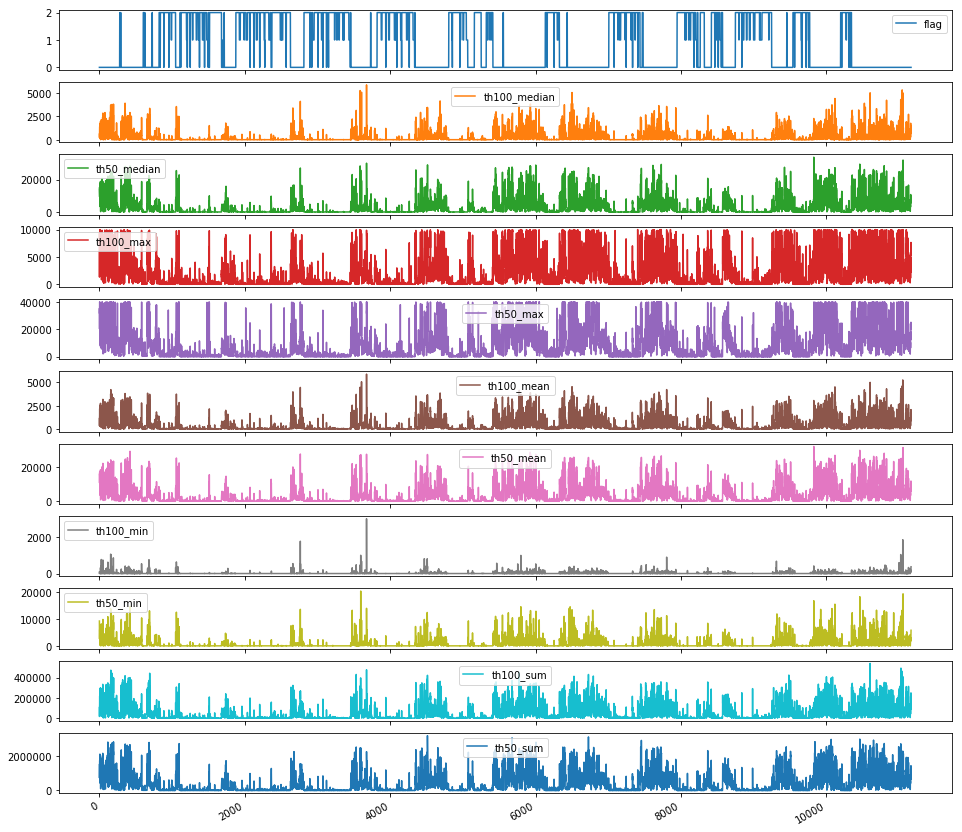

In [477]:
table_merged.plot(figsize=(16,16), subplots=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3d3212b0>,
      dtype=object)

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


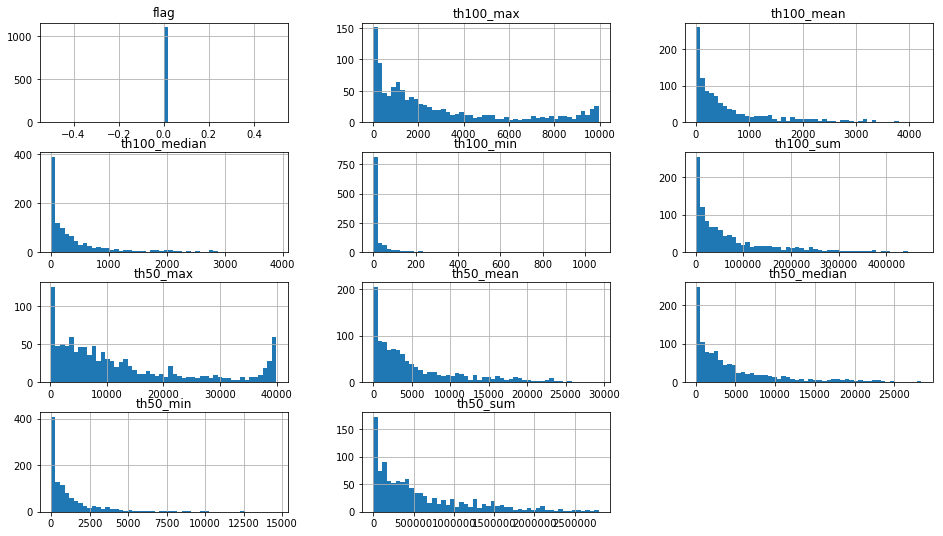

In [293]:
table_merged[table_merged['flag'] == 0].hist(figsize=(16,9), bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3d8a0748>,
      dtype=object)

/Users/ryof-mbp/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


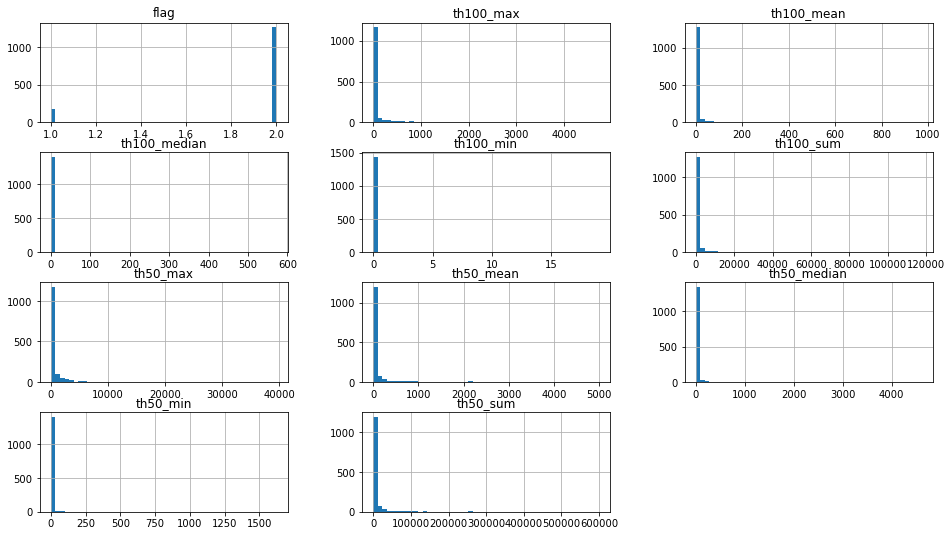

In [294]:
table_merged[table_merged['flag'] != 0].hist(figsize=(16,9), bins=50)

In [240]:
grouped_table.describe()

,th100,th50,flag
count,2541.000000,2541.000000,2541.000000
mean,197.836875,2046.625148,1.061393
std,491.504369,4272.518753,0.963185
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,20.000000,1.000000
75%,133.000000,2075.000000,2.000000
max,3891.500000,28366.000000,2.000000
